In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import matplotlib as mpl
import struct
import glob
import os 
import struct
from sklearn import linear_model
import scipy.linalg
hubble = 0.73
vmax_MW = 220.0
vmax_M31 = 270.0
m_star_M31 = 10.3
m_star_MW = 6.08

%matplotlib inline

In [2]:
def load_obs(obs_name):
    dtype=[('name','|S20'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('delta_plus', 'f8'),
           ('delta_minus', 'f8'),
           ('vmag', 'f8'),
           ('delta_vmag', 'f8')]
    obs_data = np.loadtxt(obs_name, dtype=dtype)    
    return obs_data

In [3]:
def main_halos(snap_data, sort_column='mstar', single_reverse=False):
    id_sorted = np.argsort(snap_data[sort_column])
    if single_reverse:
        id_halo_A = id_sorted[0]
        main_halos_data = snap_data[id_halo_A]
    else:
        id_halo_A = id_sorted[-1]
        id_halo_B = id_sorted[-2]
        main_halos_data = snap_data[[id_halo_A, id_halo_B]]
    return main_halos_data

In [4]:
def satellite_halos(halo_data, halo_center, vmax=None, max_points=10, sort_column='vmag'):
    jj = np.argsort(halo_data[sort_column])
    tmp_halo = halo_data[jj]
    if vmax is None:
        radius = halo_center['vmax']/(10.0 * 100) * 1000 * hubble# in kpc
    else:
        radius = vmax/(10.0 * 100) * 1000  * hubble # in kpc
    print('radius', radius)
    for col in list(['x','y','z']):
        tmp_halo[col] = tmp_halo[col] - halo_center[col]
    
    r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)
    ii = (r < radius) & (r>1E-6)
    
    tmp_halo = tmp_halo[ii]
    r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)
    return tmp_halo[:max_points], np.min(r[:max_points]), np.max(r[:max_points])

In [44]:
def inertiaTensor(in_x,in_y,in_z):
    # first recenter the data
    x = in_x - np.mean(in_x)
    y = in_y - np.mean(in_y)
    z = in_z - np.mean(in_z)
    
    I=[]
    for index in range(9):
        I.append(0)
   
    I[0] = np.sum(y*y+z*z) 
    I[1] = np.sum(-y*x)    
    I[2] = np.sum(-x*z)    
    I[3] = np.sum(-y*x)    
    I[4] = np.sum(x*x+z*z) 
    I[5] = np.sum(-y*z)    
    I[6] = np.sum(-z*x)    
    I[7] = np.sum(-z*y)    
    I[8] = np.sum(x*x+y*y) 
    tensor = np.array([(I[0:3]), (I[3:6]), (I[6:9])])
    vals, vects = np.linalg.eig(tensor)  # they come out unsorted, so the command below is needed
    eig_ord = np.argsort(vals)  # a thing to note is that here COLUMN i corrensponds to eigenvalue i.
    ord_vals = vals[eig_ord]
    ord_vects = vects[:, eig_ord].T
    
    plane_vector = ord_vects[2]
    distance_to_plane = in_x * plane_vector[0]
    distance_to_plane += in_y * plane_vector[1]
    distance_to_plane += in_z * plane_vector[2]

    #use ord_vects[2] to define the plane width
    return ord_vals, plane_vector, distance_to_plane.mean(), distance_to_plane.std()

In [45]:
def get_best_plane(pos_satellites, plotting=False, unit_vector=np.array([1.0,0.0,0.0])):
    """
    Input:
    pos_satellites: Numpy structured array with the satellites positions 
                    assuming that the halo centar is at 0.0,0.0,0.0.
    """
    
    #fit the best plane with a linear regresion, this will be used for a first guess
    regr = linear_model.LinearRegression()
    X_fit = np.array([pos_satellites[0,:], pos_satellites[1,:]])
    Y_fit = np.array(pos_satellites[2,:])
    regr.fit(X_fit.T, Y_fit.T)

    #create vectors defining the planes
    #print('n satellites {}'.format(np.shape(pos_satellites)))
    n_vectors = 10000
    costheta = (np.random.random(n_vectors)-0.5)*2.0
    theta = np.cos(costheta)
    phi = np.random.random(n_vectors) * 2.0 * np.pi
    unit_vectors = np.zeros((n_vectors,3))
    unit_vectors[:,0] = np.sin(theta) * np.cos(phi)
    unit_vectors[:,1] = np.sin(theta) * np.sin(phi)
    unit_vectors[:,2] = np.cos(theta)
    
    #replace the answer from the linear fit to be the first guess. This should be the right answer for 3 points!
    # i.e. we should get a plane of zero width for three points using this vector.
    unit_vectors[0,0] = regr.coef_[0]
    unit_vectors[0,1] = regr.coef_[1]
    unit_vectors[0,2] = -1.0
    unit_vectors[0,:] = unit_vectors[0,:]/(np.sqrt(np.sum(unit_vectors[0,:]**2)))
    
    
    # find distances of all points to all planes
    distances_to_planes = np.dot(unit_vectors, pos_satellites)
    percentiles = np.percentile(distances_to_planes, [16,50,84], axis=1)
    delta_plane = percentiles[2,:]-percentiles[0,:]
    
    # the best plane is the one with the minimum width
    i_min = np.argmin(delta_plane)
    
    #i_min = np.argmax(delta_plane)
    
    plane_delta = delta_plane[i_min]
    plane_center = percentiles[1,i_min]
    plane_vector = unit_vectors[i_min,:]
    
    if plotting:
        plt.scatter(delta_plane, percentiles[1,:], s = 0.1)
        #print(percentiles[:,i_min], distances_to_planes[i_min, :], pos_satellites)
    #print("plane vector", plane_vector)
    return plane_delta, plane_center, plane_vector

In [46]:
def gen_random_sphere(n_points):
    """
    Sets of points in the 3D sphere
    """
    r = np.random.random(n_points)**(1.0/3.0)
    phi = np.random.random(n_points) * 2.0 * np.pi
    costheta = 2.0*(np.random.random(n_points) -0.5)
    theta = np.arccos(costheta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [47]:
def spherical_randomize(x_in, y_in, z_in):
    """
    Randomizes a set of points around the coordinates origin.
    """
    n_points = len(x_in)
    r = np.sqrt(x_in**2 + y_in**2 + z_in**2)
    phi = np.random.random(n_points) * 2.0 * np.pi
    costheta = 2.0*(np.random.random(n_points) -0.5)
    theta = np.arccos(costheta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [48]:
def sample_plane_width(x_in, y_in, z_in , n_realizations=100):
    """
    Sample the best plane width for  different n_points
    """

    p_width_all = np.zeros(n_realizations)
    p_center_all = np.zeros(n_realizations)
    for i in range(n_realizations):
        x, y, z = spherical_randomize(x_in, y_in, z_in)
        pos = np.array([x,y,z])
        p_width_all[i], p_center_all[i] , q = get_best_plane(pos)
        

    return p_width_all.mean(), p_width_all.std(), p_center_all.mean(), p_center_all.std()

In [49]:
def write_inertia_plane(output_stream, satellite_data, center_data, unit_vector=[0,0,1], randomized=False):
    # inertia tensor
    if randomized :
        new_x, new_y, new_z = spherical_randomize(satellite_data['x'], satellite_data['y'], satellite_data['z'])
        values, vec_a,  center, width = inertiaTensor(new_x, new_y, new_z)
    else:
        values, vec_a, center, width = inertiaTensor(satellite_data['x'], satellite_data['y'], satellite_data['z'])
    
    output_stream.write("{:.2e}  {:.2e}  {:.2e}\t".format(values[0], values[1], values[2]))
    mu_I = 0
    for i in range(3):
        mu_I += vec_a[i]* unit_vector[i]
        
    output_stream.write("{:.4f} {:.4f} {:.4f}\t".format(center, width, mu_I))
    return
    

def write_center_info(output_stream, center_A, center_B):
    #distance between halos in kpc/h and vector connecting the two halos
    r_AB = np.ones(3)
    r_AB[0] = center_A['x'] - center_B['x']
    r_AB[1] = center_A['y'] - center_B['y']
    r_AB[2] = center_A['z'] - center_B['z']
    d_AB =  np.sqrt(np.sum(r_AB**2))
    r_AB = r_AB/d_AB
    return r_AB

In [50]:
def make_LG_stats(n_sat_max=3, n_random=1000, data_path = "../data/mstar_selected/", output_path = "../data/obs_summary/"):
    MW_data = load_obs("../data/obs/MW_satellites.txt")
    M31_data = load_obs("../data/obs/M31_satellites.txt")
    
    MW = main_halos(MW_data, sort_column='vmag', single_reverse=True)
    M31 = main_halos(M31_data, sort_column='vmag', single_reverse=True)
    
    satellite_data_A, min_r_MW, max_r_MW = satellite_halos(MW_data, MW, vmax=vmax_MW, max_points=n_sat_max)
    satellite_data_B, min_r_M31, max_r_M31 = satellite_halos(M31_data, M31, vmax=vmax_M31, max_points=n_sat_max)
 
    #number of bright satellites
    N_A = len(satellite_data_A)
    N_B = len(satellite_data_B)

    # bright satellites
    print('N bright:!', N_A, N_B)
    
    output_A = open(os.path.join(output_path, "halo_M31_nmax_{}.dat".format(n_sat_max)), "w")
    output_B = open(os.path.join(output_path, "halo_MW_nmax_{}.dat".format(n_sat_max)), "w")

    #minimum and maximum radius for the satellites
    output_A.write("{:2f} {:2f}\t".format(min_r_M31, max_r_M31))
    output_B.write("{:2f} {:2f}\t".format(min_r_MW, max_r_MW))

    r_AB = write_center_info(output_A, M31, MW)
    r_AB = write_center_info(output_B, M31, MW)
    write_inertia_plane(output_A, satellite_data_A, M31, unit_vector=r_AB)
    write_inertia_plane(output_B, satellite_data_B, MW, unit_vector=r_AB)
    output_A.write("\n")
    output_B.write("\n")
    
    for i in range(n_random):
        output_A.write("{:2f} {:2f}\t".format(min_r_M31, max_r_M31))
        output_B.write("{:2f} {:2f}\t".format(min_r_MW, max_r_MW))
        r_AB = write_center_info(output_A, M31, MW)
        r_AB = write_center_info(output_B, M31, MW)
        write_inertia_plane(output_A, satellite_data_A, M31, unit_vector=r_AB, randomized=True)
        write_inertia_plane(output_B, satellite_data_B, MW, unit_vector=r_AB, randomized=True)

        output_A.write("\n")
        output_B.write("\n")

    output_A.close()
    output_B.close()
    

In [51]:
for i in range(3,16):
    make_LG_stats(n_sat_max=i, n_random=100)

radius 160.6
radius 197.1
N bright:! 3 3
radius 160.6
radius 197.1
N bright:! 4 4
radius 160.6
radius 197.1
N bright:! 5 5
radius 160.6
radius 197.1
N bright:! 6 6
radius 160.6
radius 197.1
N bright:! 7 7
radius 160.6
radius 197.1
N bright:! 8 8
radius 160.6
radius 197.1
N bright:! 9 9
radius 160.6
radius 197.1
N bright:! 10 10
radius 160.6
radius 197.1
N bright:! 11 11
radius 160.6
radius 197.1
N bright:! 12 12
radius 160.6
radius 197.1
N bright:! 13 13
radius 160.6
radius 197.1
N bright:! 14 14
radius 160.6
radius 197.1
N bright:! 15 15


In [52]:
n_sat = np.arange(3,15)
n_iter = len(n_sat)
MW_summary = {}
M31_summary = {}
for i in n_sat:
    filename_MW = "../data/obs_summary/halo_MW_nmax_{}.dat".format(i)
    MW_summary[i] = np.loadtxt(filename_MW)
    filename_M31 = "../data/obs_summary/halo_M31_nmax_{}.dat".format(i)
    M31_summary[i] = np.loadtxt(filename_M31)

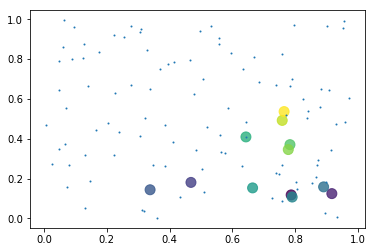

In [53]:
column = 7
MW_obs_mu_plane = np.ones(n_iter)
M31_obs_mu_plane = np.ones(n_iter)
for i in range(n_iter):
    data_M31 = M31_summary[n_sat[i]]
    M31_obs_mu_plane[i] = np.abs(data_M31[0,column])
    data_MW = MW_summary[n_sat[i]]
    MW_obs_mu_plane[i] = np.abs(data_MW[0,column])

data_M31 = M31_summary[10]
data_MW = MW_summary[10]
plt.scatter(M31_obs_mu_plane, MW_obs_mu_plane, c=n_sat, s=100, alpha=0.8)
plt.scatter(np.abs(data_M31[:,column]), np.abs(data_MW[:,column]), s=1.0)
#plt.colorbar()

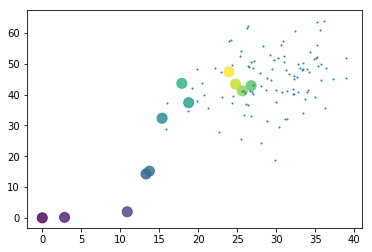

In [56]:
column = 6
MW_obs_mu_plane = np.ones(n_iter)
M31_obs_mu_plane = np.ones(n_iter)
for i in range(n_iter):
    data_M31 = M31_summary[n_sat[i]]
    M31_obs_mu_plane[i] = np.abs(data_M31[0,column])
    data_MW = MW_summary[n_sat[i]]
    MW_obs_mu_plane[i] = np.abs(data_MW[0,column])
    
data_M31 = M31_summary[12]
data_MW = MW_summary[12]
#    MW_obs_mu_plane[i] = np.abs(data_MW[0,column])
plt.scatter(M31_obs_mu_plane, MW_obs_mu_plane, c=n_sat, s=100, alpha=0.8)
plt.scatter((data_M31[:,column]), (data_MW[:,column]), s=1)
#plt.colorbar()

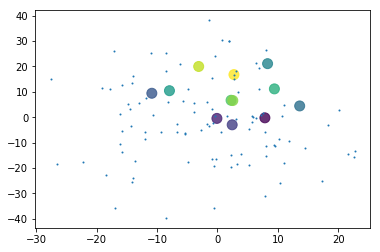

In [59]:
column = 5
MW_obs_mu_plane = np.ones(n_iter)
M31_obs_mu_plane = np.ones(n_iter)
for i in range(n_iter):
    data_M31 = M31_summary[n_sat[i]]
    M31_obs_mu_plane[i] = (data_M31[0,column])
    data_MW = MW_summary[n_sat[i]]
    MW_obs_mu_plane[i] = (data_MW[0,column])
    
data_M31 = M31_summary[14]
data_MW = MW_summary[14]
#    MW_obs_mu_plane[i] = np.abs(data_MW[0,column])
plt.scatter(M31_obs_mu_plane, MW_obs_mu_plane, c=n_sat, s=100, alpha=0.8)
plt.scatter((data_M31[:,column]), (data_MW[:,column]), s=1)
#plt.colorbar()

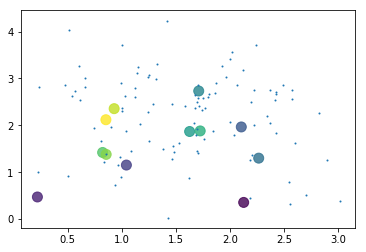

In [55]:
column = 5
MW_obs_mu_plane = np.ones(n_iter)
M31_obs_mu_plane = np.ones(n_iter)
for i in range(n_iter):
    data_M31 = M31_summary[n_sat[i]]/np.sqrt(n_sat[i])
    M31_obs_mu_plane[i] = np.abs(data_M31[0,column])
    data_MW = MW_summary[n_sat[i]]/np.sqrt(n_sat[i])
    MW_obs_mu_plane[i] = np.abs(data_MW[0,column])
    
data_M31 = M31_summary[12]/np.sqrt(12)
data_MW = MW_summary[12]/np.sqrt(12)
#    MW_obs_mu_plane[i] = np.abs(data_MW[0,column])
plt.scatter(np.sqrt(M31_obs_mu_plane), np.sqrt(MW_obs_mu_plane), c=n_sat, s=100, alpha=0.8)
plt.scatter(np.sqrt(np.abs(data_M31[:,column])), np.sqrt(np.abs(data_MW[:,column])), s=1)
#plt.colorbar()